## Modelowanie wieloagentowe

### Bogumił Kamiński

In [85]:
using Statistics

In [86]:
using Plots

In [87]:
using Random
Random.seed!(42)

TaskLocalRNG()

## 1. Podstawy projektowania i analizy wyników eksperymentu symulacyjnego

Gramy w taką grę.

Losujemy liczby z rozkładu $U(0,1)$ tak długo aż ich suma przekroczy $1$. Jaka jest wartość oczekiwana liczby losowań.

Oznaczmy przez $X$ zmienną losową oznaczającą liczbę losowań. Ponieważ jest to liczba nieujemna mamy:

$$
E(X) = \sum_{i=1}^{+\infty}\Pr(X\geq i)
$$

Niech $U_i\sim U(0,1)$, wtedy mamy:

$$
\Pr(X\geq i) = \Pr\left(\sum_{k=1}^{i-1} U_k \leq 1\right) = \frac{1}{(i-1)!}
$$

a więc:

$$
E(X) = \sum_{i=0}^{+\infty}\frac{1}{i!} = e
$$

In [88]:
function esample()
    i = 0
    s = 0.0
    while true
        i += 1
        s += rand()
        s > 1.0 && return i
    end
end

esample (generic function with 1 method)

Chcemy oszacować wartość oczekiwaną wyniku symulacji z *dokładnością* równą 0.01 z poziomem ufności 95%.
Poprzez *dokładność* $w$ będziemy rozumieli szerokość przedziału ufności.

Reguła kciuka to:

$$
n = \frac{16\hat{\sigma}^2}{w^2}
$$

gdzie $\hat{\sigma}^2$ to oszacowanie wariancji rozkładu badanej zmiennej.

Procedura:
1. przeprowadzamy wstępne symulacje, żeby zebrać wyniki dla oszacowania wielkości próby
2. przeprowadzamy symulację właściwą

In [89]:
@time burnin = [esample() for _ in 1:1024]

  0.027679 seconds (46.20 k allocations: 2.473 MiB, 98.51% compilation time)


1024-element Vector{Int64}:
 3
 2
 3
 3
 4
 3
 2
 3
 2
 2
 2
 2
 2
 ⋮
 3
 2
 3
 3
 2
 3
 3
 4
 4
 2
 2
 3

In [90]:
w = 0.01

0.01

In [91]:
n = round(Int, 16*var(burnin) / w^2)

130830

In [92]:
experiment = [esample() for _ in 1:n]

130830-element Vector{Int64}:
 3
 3
 3
 2
 2
 4
 3
 2
 2
 2
 3
 2
 2
 ⋮
 2
 2
 5
 3
 4
 3
 2
 3
 4
 2
 2
 3

In [93]:
dist = [mean(rand(experiment, length(experiment))) for _ in 1:10_000]

10000-element Vector{Float64}:
 2.7152335091339905
 2.7210884353741496
 2.721096078880991
 2.715967285790721
 2.7193992203623023
 2.7209661392646947
 2.717304899487885
 2.7191011235955056
 2.715844989681266
 2.718795383321868
 2.7183520599250937
 2.719552090499121
 2.7170755942826568
 ⋮
 2.7172743254605214
 2.7204540243063517
 2.719674386608576
 2.713941756477872
 2.721432393181992
 2.7157838416265383
 2.718344416418253
 2.7161277994343807
 2.725131850493006
 2.715929068256516
 2.7143086448062372
 2.718183902774593

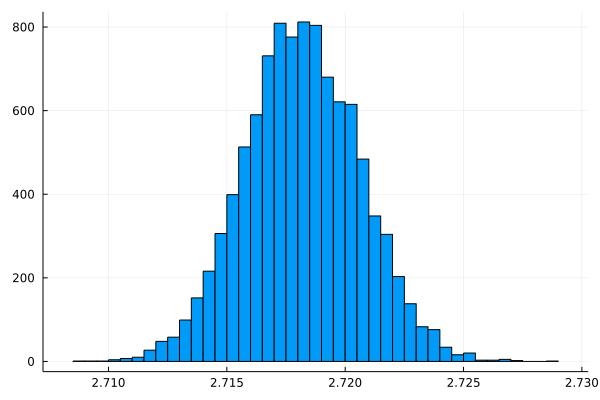

In [94]:
histogram(dist, legend=false)

In [95]:
q = quantile(dist, [0.025, 0.975])

2-element Vector{Float64}:
 2.7134753114729038
 2.7229765726515325

In [96]:
diff(q)

1-element Vector{Float64}:
 0.009501261178628706

In [97]:
q .- exp(1)

2-element Vector{Float64}:
 -0.004806516986141318
  0.004694744192487388

### Zadanie

Wróćmy do omawianego wcześniej modelu wyceny opcji:

In [98]:
using Statistics

function v_asian_sample(T, r, K, σ, X₀, m)
    X = X₀
    hatX = zero(X)
    Δ = T / m
    for i in 1:m
        X *= exp((r-σ^2/2)*Δ + σ*sqrt(Δ)*randn())
        hatX += X
    end
    return exp(-r*T) * max(hatX/m - K, 0)
end
"""
    v_asian(T, r, K, σ, X₀, m, n)

Aruments:
* T: contract period
* r: interest rate
* K: threshold price
* σ: asset price volatility
* X₀: initial price
* m: simulation granularity
* n: number of simulation replications
"""
function v_asian(T, r, K, σ, X₀, m, n)
    res = [v_asian_sample(T, r, K, σ, X₀, m) for i in 1:n]
    return mean(res)
end

v_asian

Dla wyjściowej parametryzacji:

In [99]:
v_asian(1.0, 0.05, 55.0, 0.3, 50.0, 1000, 1000)

2.016628281123545

1. Wylicz ile jest potrzeba powtórzeń eksperymentu, żeby zrobić wycenę opcji z dokładnością 0.2 na 95% poziomie ufności.
2. Zwizualizuj jak wycena opcji zależy od parametru $K$.

## Zadanie 1

In [100]:
@time burnin_asian = [v_asian_sample(1.0, 0.05, 55.0, 0.3, 50.0, 1000) for _ in 1:1024]

  0.061795 seconds (139.10 k allocations: 7.937 MiB, 19.85% gc time, 77.17% compilation time)


1024-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.48608062965764737
  0.0
  0.0
 22.243377587658205
  5.79070832737196
  8.55041062870089
  3.0826509962207425
  0.0
  2.717432378437861
  0.0
  ⋮
  7.047735060783068
  0.0
  5.544452969909696
 12.075856836739655
  0.0
  0.0
  5.167356151223985
  0.0
 12.762404816107102
  0.0
  0.0
  9.384814872727947

In [101]:
w_asian = 0.2

0.2

In [102]:
n = round(Int, 16*var(burnin_asian) / w_asian^2)

7114

In [103]:
experiment = [v_asian_sample(1.0, 0.05, 55.0, 0.3, 50.0, 1000) for _ in 1:n]
dist = [mean(rand(experiment, length(experiment))) for _ in 1:10_000]


2-element Vector{Float64}:
 -0.7738001217566814
 -0.562257002567351

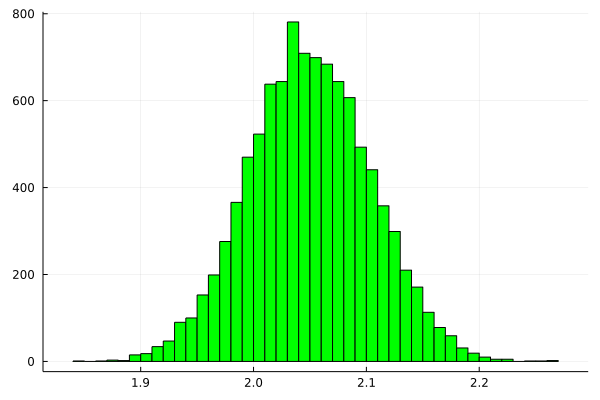

In [121]:
histogram(dist, legend=false, color="lime")

In [112]:
q = quantile(dist, [0.025, 0.975])
diff(q)
q .- exp(1)

2-element Vector{Float64}:
 -0.7738001217566814
 -0.562257002567351

In [104]:
experiment

7114-element Vector{Float64}:
  0.0
 28.772872482986703
  0.0
  0.0
  0.0
 11.754924318500754
 16.843521712352715
  0.0
  0.0
  2.641200424364461
  1.0451066783764347
  6.960703155385344
  6.012227468190798
  ⋮
 21.110592669582456
  0.0
  1.6137923086102894
  0.0
  2.3106297583282034
  0.0
  0.0
  4.350497640391112
  0.0
  0.0
  0.0
  0.0

## Zadanie 2

In [105]:
K = 5:5:100

5:5:100

In [106]:
res = []
for k in K
    burnin_asian = [v_asian_sample(1.0, 0.05, k, 0.3, 50.0, 1000) for _ in 1:1024]
    w_asian = 0.2
    n = round(Int, 16*var(burnin_asian) / w_asian^2)
    push!(res, n)
end

In [107]:
res

20-element Vector{Any}:
 30539
 31261
 28087
 28057
 30988
 27783
 27588
 26763
 21600
 13801
  8127
  4490
  1814
   951
    39
    29
    19
     0
     0
     0

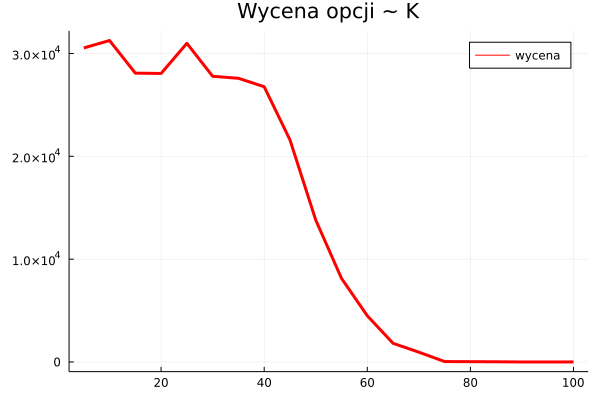

In [119]:
using Plots
x = K; y = res
plot(x, y, title = "Wycena opcji ~ K", label = "wycena", lw = 3, color="red")